## The Classic

[Link to the problem](https://fivethirtyeight.com/features/how-to-cross-the-street/)
[Link to the solution](https://fivethirtyeight.com/features/how-fast-can-you-type-a-million-letters/)

Oh man, as someone from Los Angeles I loved this problem and have thought about it independently for some time.  The situation is expressed concisely like this: in Downtown LA there is a marvelous grid of intersections that one has to navigate as they walk around, and because of the traffic and tendancy for hit-and-runs, not as muny people jay-walk here as they do in other cities.  So, the question is how to best traverse the grid under different conditions.  For example, on my commute to work I often have to make a choice: I can walk the legs of a right triangle or walk the hypotenuse.  I being the graduate of elementary trig, I know that I should aways try to walk the hypotenuse.  However, what if I would have to wait for a red light before being able to?  Then it might not be worth it to wait and just walk the legs?  Well, lets find out!

In [1]:
import random
import numpy as np
from copy import deepcopy
from tqdm import tqdm, tqdm_notebook

## Developing a Simulator of the Environment

In this situation we are hoping that we might be able to understand the best possible set of actions by sampling from the possibilities.  Before we can plug this into the Monte Carlo though, we need a simulator of the problem.  For this problem we construct the Grid class, which constructs an arbitrary street grid from a designated number of streets and cross streets.  Grid also manages the rules which allows us transition from state to state.

In [2]:
class Grid(object):
    def __init__(self, streets, cross_streets, timer_max=10, start_point=(0, 0), end_point=(0, 0)):
        self.streets = streets
        self.cross_streets = cross_streets
        self.timer_max = timer_max
        self.intersection_state = self.initialize_intersections(streets, cross_streets)
        self.timer_state = self.initialize_timers(streets, cross_streets, timer_max=timer_max)
        self.grid = np.zeros((2*streets, 2*cross_streets))
        self.set_start_end(start_point, end_point)
        self.current_location = np.array(start_point)
        self.goal_location = np.array(end_point)
    
    @staticmethod
    def initialize_intersections(streets, cross_streets): 
        """Initializes the intersection array

        If an intersection is a 0, then it is green in the x direction
        else it's green in the y direction
        """
        return np.random.choice((0, 1), size=(streets, cross_streets))

    @staticmethod
    def initialize_timers(streets, cross_streets, timer_max=10):
        """Initializes the street timer array

        Each spot contains a value between 0 and the max_timer, which 
        successively counts up to the max and then resets.
        """
        return np.random.choice(range(timer_max), size=(streets, cross_streets))

    def tick_timer(self):
        """Increases all timers by 1 and resets """
        return (self.timer_state + 1) % self.timer_max
    
    def tick_lights(self):
        """If a timer resets, flips the corresponding bit in walk signal"""
        return (self.intersection_state + (self.timer_state == 0)) % 2
    
    def tick_state(self):
        self.timer_state = self.tick_timer()
        self.intersection_state = self.tick_lights()
        
    def set_start_end(self, start, end):
        """Provide start, end as tuples"""
        self.grid[start] = 1
        self.grid[end] = 10
        
    def coord_in_grid(self, x, y):
        in_x = x in range(2*(self.streets))
        in_y = y in range(2*(self.cross_streets))
        return in_x and in_y
    
    def list_valid_moves(self):
        """Find valid movement options from the list of all possibilities"""
        options = np.array([(-1, 0), (1, 0), (0, 1), (0, -1), (0, 0)])
        valid = [self.coord_in_grid(*(self.current_location + option)) 
                 for option in options]
        return options[valid]
    
    @staticmethod
    def get_intersection(coord): return np.floor(coord / 2)
    
    def cost_wait_time(self, move):
        """Calulate the cost of the indicated move in terms of wait time and travel
        
        Uses internal state for current location and intersection/timer states
        and then calculates the cost of that move. 
        """
        loc, intr = self.current_location, self.get_intersection(self.current_location).astype('int')
        intr_state, timr_state = self.intersection_state[tuple(intr)], self.timer_state[tuple(intr)]
        
        if sum(move) > 0:
            #print("Increasing case")
            # if old loc is even and new loc is odd
            # then we're crossing an intersection
            if loc[move != 0] % 2 == 0:
                #print("Crossing Intersection")
                cost = (move[intr_state] * (10 - timr_state)) + 1
            # else we're on the sidewalk
            else:
                #print("On sidewalk")
                cost = 1
        elif sum(move) < 0:
            #print("Decreasing case")
            if loc[move != 0] % 2 == 0:
                #print("On sidewalk")
                cost = 1
            else:
                #print("Crossing Intersection")
                cost = (np.abs(move[intr_state]) * timr_state) + 1   
        else:
            cost = 1
        return cost
    
    def dist_cost(self, move):
        """We also need to penalize moves that take us away from the goal
        
        We'll use a simple cost functions that consists of the square of the
        differences in the components.
        """
        new_loc = self.current_location + move
        return np.linalg.norm(self.goal_location - new_loc)
    
    def total_cost(self, move): return self.dist_cost(move) + self.cost_wait_time(move)
    
    def set_initial_conditions(self, coord=np.array((0, 0)), light_state=0, timer_state=9):
        """The problem statement is actually interested in a decision """
        intr = tuple(self.get_intersection(coord).astype('int'))
        #print(intr)
        self.intersection_state[intr] = light_state
        self.timer_state[intr] = timer_state
        
    def is_victorious(self): return tuple(self.current_location) == tuple(self.goal_location)
    
    def move(self, move):
        self.grid[tuple(self.current_location)] = 0
        self.current_location += np.array(move)
        self.grid[tuple(self.current_location)] = 1

Phew, just as a check we'll look at a few examples.  We can create a Grid here with 2 streets and 3 cross streets.  We'll start somewhere in the middle so that we have all 4 moves available as well. One quick thing to check is that we can monitor the state of the intersection over time.

In [3]:
start = (0, 0)
end = (3, 5)
grid = Grid(2, 3, start_point=start, end_point=end)

In [4]:
for i in range(4):
    print(grid.timer_state)
    print(grid.intersection_state)
    grid.tick_state()
    print("--------- Next State ----------")

[[4 7 0]
 [7 3 9]]
[[1 1 1]
 [1 0 1]]
--------- Next State ----------
[[5 8 1]
 [8 4 0]]
[[1 1 1]
 [1 0 0]]
--------- Next State ----------
[[6 9 2]
 [9 5 1]]
[[1 1 1]
 [1 0 0]]
--------- Next State ----------
[[7 0 3]
 [0 6 2]]
[[1 0 1]
 [0 0 0]]
--------- Next State ----------


Our agent might do something like list all possible moves from their current point and then choose the one with the lease score.  So fore example it might look like:

In [25]:
possible_moves = grid.list_valid_moves()
possible_moves

array([[1, 0],
       [0, 1],
       [0, 0]])

In [26]:
waittime = [grid.total_cost(move) for move in possible_moves]
waittime

[6.385164807134504, 8.0, 6.830951894845301]

And so in this case we would choose the move (0, 1) which had the lowest cost.

## Our Agent

Now that we have a sufficient simulator, lets get to work on the agent to solve this problem.

In [27]:
class NaiveAgent(object):
    def __init__(self):
        self.step_count = 0
    
    def solve(self, grid, verbose=0):
        if verbose: print(grid.grid)
        while grid.is_victorious() == False:
            # While we haven't reached the finish point
            # List possible moves
            possible_moves = grid.list_valid_moves()
            # Calculate the cost for each one
            wait_times = [grid.total_cost(move) for move in possible_moves]
            # Select the best move
            best = possible_moves[np.array(wait_times) == min(wait_times)]
            # We should check if there is more than one best move, and then randomly choose between them
            if verbose: print(best)
            if len(best) > 1:
                if verbose: print("Multiple good moves")
                # If there are multiple good moves then 
                best = best[random.randint(0, len(best)-1), :]
            
            if len(best.shape) > 1:
                best = best[0]
                
            # Update the Grid with our choice
            grid.move(best)
            self.step_count += 1
            # Print current state
            if verbose: print(grid.grid)
            # Tick the state
            grid.tick_state()

In [28]:
import seaborn as sns
class SamplePaths(object):
    def __init__(self, agent, grid_args):
        self.grid_args = grid_args
        self.agent = agent
        
    def sample(self, n_samples=5, verbose=False, initial_timer=0):
        history = []
        for i in tqdm_notebook(range(n_samples)):
            run_grid = Grid(**self.grid_args)
            # Set the grid the conditions specified in the problem. 
            run_grid.set_initial_conditions(coord=np.array((0, 0)), light_state=0, timer_state=5)
            run_agent = deepcopy(self.agent)
            run_agent.solve(run_grid, verbose=verbose)
            history.append(run_agent.step_count)
        return history
     
    def plot_history(self, history):
        sns.distplot(history)

Let's demo a single run with our sampler

In [29]:
args = dict(streets=2,
            cross_streets=3,
            timer_max=10,
            start_point=(1, 0),
            end_point=(2, 4))
agent = NaiveAgent()
sampler = SamplePaths(agent, args)
history = sampler.sample(n_samples=1, verbose=True, initial_timer=5)

HBox(children=(IntProgress(value=0, max=1), HTML(value='')))

[[ 0.  0.  0.  0.  0.  0.]
 [ 1.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0. 10.  0.]
 [ 0.  0.  0.  0.  0.  0.]]
[[0 1]]
[[ 0.  0.  0.  0.  0.  0.]
 [ 0.  1.  0.  0.  0.  0.]
 [ 0.  0.  0.  0. 10.  0.]
 [ 0.  0.  0.  0.  0.  0.]]
[[0 1]]
[[ 0.  0.  0.  0.  0.  0.]
 [ 0.  0.  1.  0.  0.  0.]
 [ 0.  0.  0.  0. 10.  0.]
 [ 0.  0.  0.  0.  0.  0.]]
[[0 1]]
[[ 0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  1.  0.  0.]
 [ 0.  0.  0.  0. 10.  0.]
 [ 0.  0.  0.  0.  0.  0.]]
[[1 0]
 [0 1]]
Multiple good moves
[[ 0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  1. 10.  0.]
 [ 0.  0.  0.  0.  0.  0.]]
[[0 1]]
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0.]]



When we do many samples, we can also get a histogram of all of the step counts.

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

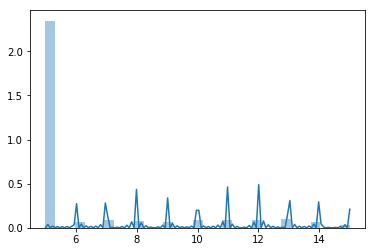

In [30]:
history = sampler.sample(n_samples=1000, verbose=False)
sampler.plot_history(history)

So let's now set up the same grid, but adjust the starting points 

HBox(children=(IntProgress(value=0, max=3000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=3000), HTML(value='')))

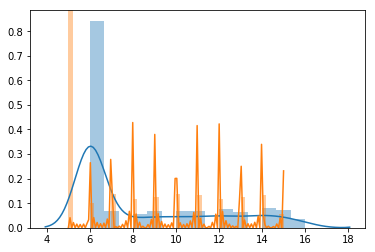

In [11]:
# Models where we step to the right
sp1 = dict(streets=2,
            cross_streets=3,
            timer_max=10,
            start_point=(0, 1),
            end_point=(2, 4))
# Models starting where we step down
sp2 = dict(streets=2,
            cross_streets=3,
            timer_max=10,
            start_point=(1, 0),
            end_point=(2, 4))
# Create the samplers for the agents in different starting points
sample_right = SamplePaths(agent, sp1)
sample_down = SamplePaths(agent, sp2)
# The history for moving right will get 1 addition step added
history_right = np.array(sample_right.sample(n_samples=3000, verbose=False, initial_timer=0)) + 1
history_down = np.array(sample_down.sample(n_samples=3000, verbose=False, initial_timer=0))
# Plot results
sample_right.plot_history(history_right)
sample_down.plot_history(history_down)

In [20]:
sample_down.sample(n_samples=1, verbose=True, initial_timer=0)

HBox(children=(IntProgress(value=0, max=1), HTML(value='')))

[[ 0.  0.  0.  0.  0.  0.]
 [ 1.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0. 10.  0.]
 [ 0.  0.  0.  0.  0.  0.]]
[[0 1]]
[[ 0.  0.  0.  0.  0.  0.]
 [ 0.  1.  0.  0.  0.  0.]
 [ 0.  0.  0.  0. 10.  0.]
 [ 0.  0.  0.  0.  0.  0.]]
[[0 1]]
[[ 0.  0.  0.  0.  0.  0.]
 [ 0.  0.  1.  0.  0.  0.]
 [ 0.  0.  0.  0. 10.  0.]
 [ 0.  0.  0.  0.  0.  0.]]
[[1 0]]
[[ 0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.]
 [ 0.  0.  1.  0. 10.  0.]
 [ 0.  0.  0.  0.  0.  0.]]
[[0 1]
 [0 0]]
Multiple good moves
[[ 0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  1. 10.  0.]
 [ 0.  0.  0.  0.  0.  0.]]
[[0 1]]
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0.]]



[5]

In [12]:
history_right.mean(), history_down.mean()

(8.362666666666666, 6.257333333333333)

In [13]:
history_right.mean(), history_right.std()

(8.362666666666666, 3.2308625611265)

In [14]:
history_down.mean(), history_down.std()

(6.257333333333333, 2.6108324768591)

## They got it wrong!

So, my work simulating this situation had led me to believe that the submitted answer to the Riddler was incorrect.  They offer the solution that the agent which steps to the right would actually be the ideal solution, and goes through a process of backwards processing to establish the expected value value.  However, the author of the solution excludes what is likely the fastest path, and thus provides an incorrect proof. While our work above provides an indication that the author of the solution is wrong, we can verify analytically with their own method.

They submitted the following picture, showing how if we go north that the expected time to the endpoint from that intersection would be roughly `2T/4`.  
![Their Thing](images/intersection_path_submitted.png)

However, as you can see they only really consider a subset of possible path, and critically missed an important thing we actually know at the start.  When we head north, because of the timer to the right we know that the light will change precisely when we get to the other end of the intersection.  This allows a cheat!  Because we now know that we can cross the same intersection (0, 0) a second time for free.  This cheat allows us to walk north, but also avoid the trap of that intersection in the corner. 
![My thing](images/intersection_path_minev2.png)

As I was calculating expected paths, I kept track of steps in addition to the time spent at intersection, as I hypothesized that a small constant different would be the only difference.  However, it turns out that by accounting for this shortcut, we actually find that either path is as long.  Because we would have to wait for the timer in either case, this result is also invarient under different starting amount on the timers.

In [127]:
sample_down.sample(n_samples=1, verbose=1)

HBox(children=(IntProgress(value=0, max=1), HTML(value='')))

[[ 0.  0.  0.  0.  0.  0.]
 [ 1.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0. 10.  0.]
 [ 0.  0.  0.  0.  0.  0.]]
[[1 0]]
[[ 0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.]
 [ 1.  0.  0.  0. 10.  0.]
 [ 0.  0.  0.  0.  0.  0.]]
[[0 0]]
[[ 0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.]
 [ 1.  0.  0.  0. 10.  0.]
 [ 0.  0.  0.  0.  0.  0.]]
[[0 0]]
[[ 0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.]
 [ 1.  0.  0.  0. 10.  0.]
 [ 0.  0.  0.  0.  0.  0.]]
[[0 0]]
[[ 0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.]
 [ 1.  0.  0.  0. 10.  0.]
 [ 0.  0.  0.  0.  0.  0.]]
[[0 0]]
[[ 0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.]
 [ 1.  0.  0.  0. 10.  0.]
 [ 0.  0.  0.  0.  0.  0.]]
[[0 1]
 [0 0]]
Multiple good moves
[[ 0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.]
 [ 0.  1.  0.  0. 10.  0.]
 [ 0.  0.  0.  0.  0.  0.]]
[[0 1]]
[[ 0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.]
 [ 0.  0.  1.  0. 10.  0.]
 [ 0.  0.  0.  0.  0.  0.]]
[[0 1]]
[[ 0.  0.  0.  0.  0.  0.]
 [ 0.  0. 

[9]

# Express

Given a set of small circles whose origins lie on a larger circle and whose edges just touch, we are asked about the relationship between the radius of the smaller circle and of the larger circles.

In [24]:
import math
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
from matplotlib.collections import PatchCollection
import numpy as np
%matplotlib inline

In [99]:
def calculate_origins(n, radius):
    """For a cirlce of given radius, calculate origins for equidistant circles on the ring"""
    start = (1*radius, 0)
    origins = []
    for i in range(n):
        origins.append((radius*math.cos((2*math.pi*i)/n),
                        radius*math.sin((2*math.pi*i)/n)))
    return origins

def add_circle(ax, xy, radius):
    x, y = xy
    patches = []
    patches.append(Circle((x, y), radius))
    p = PatchCollection(patches, alpha=0.4)
    ax.add_collection(p)
    return ax

def get_small_radius(origins):
    """Calculate the radius of smaller circles on the ring of a large circle"""
    return np.linalg.norm(np.array(origins[1])-np.array(origins[0]))/2

In [110]:
N = 5

In [111]:
def draw_weaving_circles(N):
    # Set an arbitrary radius for the figure
    radius = 5
    # Calculate the points for our origins.  The first point is always (radius, 0)
    origins = calculate_origins(N, radius)
    # From our orgins, calculate the radius of the smaller circles
    r = get_small_radius(origins)
    fig, ax = plt.subplots(figsize=(5, 5))
    ax = draw_ring(ax, (0, 0), radius)
    for origin in origins:
        draw_ring(ax, origin, r)
    ax.set_xlim(-10, 10)
    ax.set_ylim(-10, 10)
    plt.show()

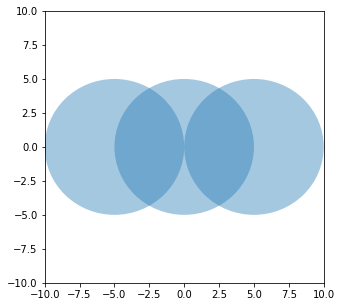

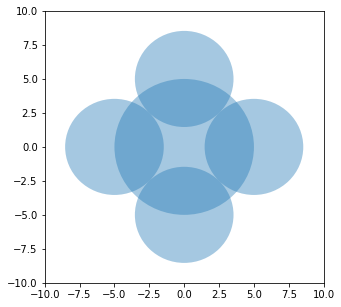

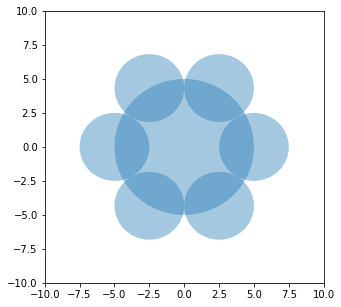

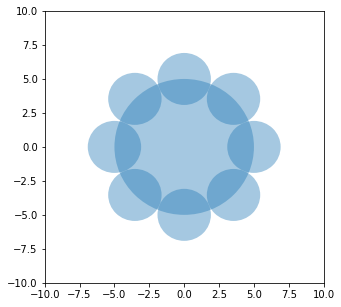

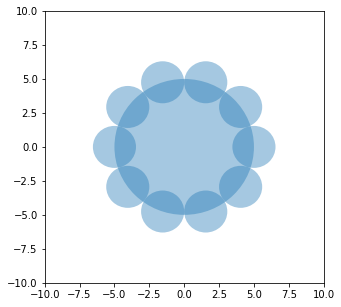

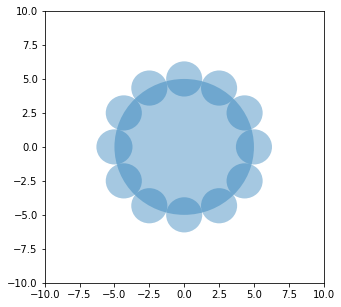

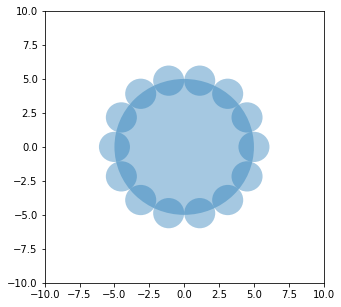

In [117]:
for i in range(2, 15, 2):
    draw_weaving_circles(i)